## Dataset: model_dataset

<img src="./images/model_dataset.png"/>

Explanation for part of columns:  
1. label_group (obeject): 4 groups of resonse to offers
    - 'none_offer'
    - 'no_care'
    - 'tried'
    - 'effective_offer'
2. label_seg (int): 12 segments based on age and income
    - values: 1 ... 12  <br>  
  
(More details in <u>2_heuristic_exploration.ipynb</u>)

###  <u>10 Kinds</u> of offer_id
| offer_id #| type | duration | requirement | reward |
|:-| :-| :-:|:-:|:-:|
| 0 | bogo | 7 | 10 | 10 |
| 1 | bogo | 5 | 10 | 10 |
| 2 | infomational | 4 | - | - |
| 3 | bogo | 7 | 5 | 5 |
| 4 | discount | 10 | 20 | 5 |
| 5 | discount | 7 | 7 | 3 |
| 6 | discount | 10 | 10 | 2 |
| 7 | informational | 3 | - | - |
| 8 | bogo | 5 | 5 | 5 |
| 9 | discount | 7 | 10 | 2 |

### <u>12 Segements</u> based on 'age' and 'income'
<br>
    
|Segment #| Age Group (edge included)<br> (Experiment in 2018) | Income | 
|---| --- | --- | 
|1| Millenials(-21 & 22-37) | low  | 
|2| Millenials(-21 & 22-37) | medium  | 
|3| Millenials(-21 & 22-37) | high  | 
|4| Gen X(38-53) | low  |
|5| Gen X(38-53) | medium |
|6| Gen X(38-53) | high |
|7| Baby Boomer(54-72) | low  |
|8| Baby Boomer(54-72) | medium |
|9| Baby Boomer(54-72) | high |
|10| Silent(73-90 & 91+) |low |
|11| Silent(73-90 & 91+) | medium |
|12| Silent(73-90 & 91+) | high |

**Notice:**  
- low: 30,000-50,000
- medium: 50,001-82,500
- high: 82,501-120,000

### <u>4 Groups</u> of possible responsiveness to offer
<br>

|Group| received | viewed |valid completed | transaction amount |Scenario |
| :-| :-: | :-:| :-: | :-: | :- |
|1.none_offer| 0 | 0 | 0 | |haven't received the offer |
|2.no_care | 1 | 0 | - | |received but not viewed.<br> regarded as no_care|
|| 1 | 1 | 0 | =0.0 | received, viewed but no transaction |
|| 1 | 1 | 1<br>viewed after completed |  | received, but completed unintentionally |
|3.tried| 1 | 1 | 0 | >0.0|received, viewed, have transaction |
|4.effctive_offer | 1 | 1 | 1<br>viewed before completed | | viewed before completed,  effctive offer|

# <a class="anchor" id="Start">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Build model Pipeline](#2)<br>
III.[Explore intersting Questions](#3)  
- Q3.1 [Offer prepared to sent to a person, will this offer effective?](#3.1)
- Q3.2 [Offer already sent to a person, is this offer effective?](#3.2)
- Q3.3 [Given a person, recommend an offer with the most effctivity?](#3.3)

IV.[Build Neural Network for Regeression](#4)<br>
[References](#References)

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

model_dataset_raw = pd.read_csv('./data_generated/model_dataset_raw.csv', dtype={'offer_id': str})

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.multioutput import MultiOutputClassifier

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import pickle

## <a class="anchor" id="1">[I. Feature Engineer](#Start)</a>

### 1. Add features
- Total transactions amount of individuals `'amount_total'`
- Count of offers received of individuals  `'offer_received_cnt'`

In [5]:
# Load in transactions dataset

# wrangled transcript with updated information of 'offer_id'
transcript_offer = pd.read_csv('./data_generated/transcript_offer_wrangled.csv', dtype={'person': int})

In [8]:
# Total transactions amount of individuals 
transcript_amount = transcript_offer.groupby('person').sum()['amount']
# Count of offers received of individuals
offer_received_cnt = model_dataset_raw.groupby(['person']).count()['offer_id']

In [11]:
# person ids
persons = transcript_amount.index.tolist()

for person in persons:
    # update the two features in model_dataset_raw
    is_person = (model_dataset_raw.person == person)
    model_dataset_raw.loc[is_person,'amount_total'] = transcript_amount.loc[person]
    model_dataset_raw.loc[is_person,'offer_received_cnt'] = offer_received_cnt.loc[person]

# make an copy
model_dataset = model_dataset_raw.copy()

In [25]:
model_dataset.groupby('label_group').count()

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,mobile,social,web,gender,age,income,member_days,label_seg,amount_total,offer_received_cnt
label_group,,,,,,,,,,,,,,,,,,,,,
effctive_offer,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826,...,26826,26826,26826,26826,26826,26826,26826,26826,26826,26826
no_care,31613,31613,31613,14972,22859,13581,31613,31613,31613,31613,...,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613
none_offer,5,5,0,0,5,0,5,5,0,0,...,0,0,0,5,5,5,5,5,5,5
tried,8062,8062,8062,8062,8062,0,8062,8062,8062,8062,...,8062,8062,8062,8062,8062,8062,8062,8062,8062,8062


**FOUND:**
1. The 5 person in group `none_offer` will be droped, so that there is no more NaNs in the target columns in `model_dataset` 

In [26]:
is_dataset_kepp = (model_dataset.label_group != 'none_offer')
model_dataset = model_dataset[is_dataset_kepp]

### 2. One-hot code for target obejects
- gender
- label_group

In [27]:
gender_onehot = pd.get_dummies(model_dataset['gender'], prefix='gender')
label_group_onehot = pd.get_dummies(model_dataset['label_group'], prefix='group')
offer_id_onehot =  pd.get_dummies(model_dataset['offer_id'], prefix='offer')

In [28]:
model_dataset = pd.concat([model_dataset, gender_onehot, label_group_onehot, offer_id_onehot], axis=1)

### 3. Features of time
1. Time features
    - 'time_received'
    - 'time_viewed'
    - 'time_transaction'
    - 'time_completed'
2. Transform the time_transaction to transaction_cnt
3. Fill the NaNs with 0

In [29]:
model_dataset[(model_dataset.time_transaction.isin(['-1']))].offer_id.unique()  
# Result: '-1' exists only in offer_id (2, 7) 

array(['2', '7'], dtype=object)

In [30]:
def transform_transaction_cnt(dataset):
    '''
    DESCRIPTION:
        Since more than one transactions may exist in one offer. 
        So from the value extract the count of transactions of individuals.
        There are three diffirent situations:
        
        i. Offer id is 2, 7, value of time_transaction is float:
            - When none valid transaction, is -1 ==> len(str(x).split(','))-1 result: 0
            - When there is a valid transaction e.g. 2.0 ==> special case!!!
        
        ii. Offer id is not 2, 7, value of time_transaction is str:
            - When none valid transaction, is "" ==> len(str(x).split(','))-1 result: 0
            - When a valid transaction exists e.g. ",2.0" ==> len(str(x).split(','))-1 result: 1
            - When more than one transaction exists e.g. ",2.0,3.0" ==> len(str(x).split(','))-1 result: 2
    '''
    dataset['time_transaction'] = dataset['time_transaction'].apply(lambda x: len(str(x).split(','))-1)
    # special case: offer id is 2 or 7, and is completed(exist one valid transaction)
    is_group_info = (dataset.offer_id.isin(['2', '7']) & (dataset.label_effective_offer==1))
    dataset.loc[is_group_info, 'time_transaction'] = 1
    
    return dataset

model_dataset = transform_transaction_cnt(model_dataset)

In [31]:
model_dataset.rename(columns={'time_transaction': 'transaction_cnt'}, inplace=True)

# drop the useless columns for modeling
model_dataset.drop(['label_effective_offer'], axis=1, inplace=True)

# fill the NaNs
values = {'time_viewed': 0.0, 'time_completed': 0.0} #time_viewed: 49860 non-null, time_completed: 40407 non-null
model_dataset.fillna(value=values, inplace=True)

model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66505
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person                66501 non-null  int64  
 1   offer_id              66501 non-null  object 
 2   time_received         66501 non-null  float64
 3   time_viewed           66501 non-null  float64
 4   transaction_cnt       66501 non-null  int64  
 5   time_completed        66501 non-null  float64
 6   amount_with_offer     66501 non-null  float64
 7   reward                66501 non-null  float64
 8   difficulty            66501 non-null  float64
 9   duration              66501 non-null  float64
 10  offer_type            66501 non-null  object 
 11  email                 66501 non-null  float64
 12  mobile                66501 non-null  float64
 13  social                66501 non-null  float64
 14  web                   66501 non-null  float64
 15  gender             

## <a class="anchor" id="2">[II. Build model Pipeline](#Start)</a>

In [32]:
# make an copy
model_dataset_test = model_dataset.copy()

In [ ]:
# recover to the model_dataset
# model_dataset = model_dataset_test

### 1. Select features and target 
[References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)

In [33]:
# Target: label_group
# Change the label of group to 0-1 variables
model_dataset['label_group'] = model_dataset['label_group'].replace(['no_care','tried', 'effctive_offer'],['0','1','1'])
model_dataset = model_dataset.astype({'label_group': int})

model_dataset.groupby('label_group').count()  
# 31613	 VS 34888: The distribution of the targets seems balanced

,person,offer_id,time_received,time_viewed,transaction_cnt,time_completed,amount_with_offer,reward,difficulty,duration,...,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
label_group,,,,,,,,,,,,,,,,,,,,,
0,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613,...,31613,31613,31613,31613,31613,31613,31613,31613,31613,31613
1,34888,34888,34888,34888,34888,34888,34888,34888,34888,34888,...,34888,34888,34888,34888,34888,34888,34888,34888,34888,34888


In [34]:
def select_features_target(df, target_cols, keep_cols):
    '''
    INPUT:
        - df(DataFrame): dataset include all possible features and target
        - target_cols: 
            i. (str) a column name 
            ii. (list of str) more columns names
        - keep_cols(list): list of columns names as features
    
    OUTPUT:
        - features(DataFrame)
        - target(DataFrame)
    '''
    # df[[]] is DataFrame
    target = df[target_cols] #np.array()
    # get the drop columns names
    drop_cols = np.setdiff1d(df.columns, keep_cols)
    features = df.drop(drop_cols, axis=1)
    
    return features, target

### 2. prepare model pipeline
[References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)

In [35]:
def select_clf(pickle_path, clf_list, features, target, test_size=0.20, random_state=9):
    '''
    DESCRIPTION:
        Train and test the models with diffirent classifiers, and evaluate the model.

    INPUT:
        - pickle_path(str): the pickle file path to save models
        - clf_list(list): list of classifiers
        - features(DataFrame)
        - target(DataFrame)
        - test_size: the ratio of test set
        - random_state: control random seed

    OUTPUT:
        - results_df(DataFrame): with infomation of classifier, train time, train score, test time, test score
    '''
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                        test_size=test_size,
                                                        random_state=random_state)

    results = defaultdict()
    results_df = pd.DataFrame(columns=['model', 'train_time', 'test_time',
                                         'train_score', 'test_score'])

    for classifier in clf_list:
        pipe = Pipeline(steps=[('preprocessor', StandardScaler()),
                               ('clf', classifier)])

        train_start = time()
        model = pipe.fit(X_train, y_train)
        train_end = time()
        results['train_time'] = train_end-train_start

        # predict in train set
        pred_train = model.predict(X_train)

        # predict in test set and Calculate the time
        test_start = time()
        pred_test = model.predict(X_test)
        test_end = time()
        results['test_time'] = test_end-test_start

        # add training accuracy to results
        results['train_score']=model.score(X_train,y_train)

        #add testing accuracy to results
        results['test_score']=model.score(X_test,y_test)

        print("{} trained on {} samples.".format(classifier.__class__.__name__, len(y_train)))
        print("Train time: {}s".format(results['train_time']))
        print("Test time: {}s".format(results['test_time']))
        print("MSE_train: %.4f" % mean_squared_error(y_train,pred_train))
        print("MSE_test: %.4f" % mean_squared_error(y_test,pred_test))
        print("Training accuracy: %.4f" % results['train_score'])
        print("Test accuracy: %.4f" % results['test_score'])

        # output the report
        report = classification_report(y_test, pred_test, digits=4) #output_dict=True
        print(report)
        # df_report = pd.DataFrame(report).transpose()
        # report_ls.append(df_report)

        # for scaler value need an index
        new_model = pd.Series([classifier.__class__.__name__, results['train_time'], results['test_time'], results['train_score'], results['test_score']], index=results_df.columns)
        results_df = results_df.append(new_model, ignore_index=True)

        # Save all the models with 'ab' 
        with open(pickle_path, "ab") as f: # len = results_df.shape[0]
                pickle.dump(model, f)

    return results_df #,report_ls

In [36]:
def select_model_param(classifier, param_grid, features, target, test_size=0.20, random_state=9):
    '''
    DESCRIPTION:
        After chosen a model with classifier, try to find the best set of parameters of this model.

    INPUT:
        - classifier(clf object): the chosen classifier
        - param_grid: alternative parameters list, used to do GridSearchCV
        - features(DataFrame)
        - target(DataFrame)
        - test_size: the ratio of test set
        - random_state: control random seed

    OUTPUT:
        - model(GridSearchCV object)
        - results(dict): with infomation of train time, train score, test time, test score
    '''

    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                        test_size=test_size,
                                                        random_state=random_state)

    pipe = Pipeline(steps=[('preprocessor', StandardScaler()),
                        ('clf', classifier)])
    model = GridSearchCV(pipe, param_grid, n_jobs= 1)

    results = defaultdict()

    train_start = time()
    model.fit(X_train, y_train)  # Attribute: best_estimator_  best_params_  best_score_
    train_end = time()
    results['train_time'] = train_end - train_start

    # predict in train set
    pred_train = model.predict(X_train)

    # predict in test set and Calculate the time
    test_start = time()
    pred_test = model.predict(X_test)
    test_end = time()
    results['test_time'] = test_end-test_start

    # add training accuracy to results
    results['train_score'] = model.score(X_train,y_train)

    # add testing accuracy to results
    results['test_score'] = model.score(X_test,y_test)

    print("{} trained on {} samples.".format(model.best_estimator_, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train, pred_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test, pred_test))
    print("Training accuracy: %.4f" % results['train_score'])
    print("Test accuracy: %.4f" % results['test_score'])
    print(classification_report(y_test, pred_test,digits=4))

    return model, results

## <a class="anchor" id="3">[III. Explore intersting Questions](#Start)</a>

### <a class="anchor" id="3.1">[Q3.1 Offer prepared to sent to a person, will this offer effective?](#Start)</a>

1. Dataset: The data as follows (in label_group)
    - no_care
    - tried
    - effective_offer
<br>
2. Target   

| Target | Value | Meaning |
| :- | :-: | :- |
| label_group | 0 | person doesn't care the offer |
|       | 1 | Within the duration of offer, person tried or completed the transactions|

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| (10)offer_ | info about offer<br>(10 kinds of 0-1 variables) |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |


In [37]:
target_cols = 'label_group'

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_total', 'offer_received_cnt','time_received']
           
features, target = select_features_target(model_dataset, target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

# save the models and get results
pickle_path = './models_prepare.pckl'
results_prepare = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

KNeighborsClassifier trained on 53200 samples.
Train time: 2.9423346519470215s
Test time: 13.412032127380371s
MSE_train: 0.1824
MSE_test: 0.3376
Training accuracy: 0.8176
Test accuracy: 0.6624
              precision    recall  f1-score   support

           0     0.6421    0.6311    0.6366      6230
           1     0.6798    0.6900    0.6849      7071

    accuracy                         0.6624     13301
   macro avg     0.6609    0.6606    0.6607     13301
weighted avg     0.6621    0.6624    0.6622     13301

SVC trained on 53200 samples.
Train time: 1685.7050383090973s
Test time: 22.67504072189331s
MSE_train: 0.3005
MSE_test: 0.3036
Training accuracy: 0.6995
Test accuracy: 0.6964
              precision    recall  f1-score   support

           0     0.6717    0.6881    0.6798      6230
           1     0.7192    0.7037    0.7114      7071

    accuracy                         0.6964     13301
   macro avg     0.6955    0.6959    0.6956     13301
weighted avg     0.6970    0.6964

In [38]:
results_prepare

,model,train_time,test_time,train_score,test_score
0,KNeighborsClassifier,2.942335,13.412032,0.817613,0.662431
1,SVC,1685.705038,22.675041,0.699474,0.696414
2,NuSVC,22959.358365,43.541081,0.780620,0.703406
3,DecisionTreeClassifier,2.100798,0.068962,1.000000,0.649124
4,RandomForestClassifier,27.510256,0.927469,0.999981,0.721750
5,AdaBoostClassifier,6.932032,0.262848,0.715226,0.716788
6,GradientBoostingClassifier,25.969138,0.057967,0.730808,0.727163


### Q3.1 Summary: Will an offer effective?(before sent)
1. The first model KNeighborsClassifier	could be a reference model
    - It trains fast
2. SVC and NuSVC take more time, I attempt to continue without them.
3. DecisionTreeClassifier and RandomForestClassifier both have a high score in training, is there something speciall?
    - Notice that: the test time if much more less than train time. The possible reason is that the data set has a simple structure so that all predict with same result(see the deploy: no matter how i change the input data, it all shows the same result.)
4. For all, the accuracy of predicting is around 70%, seems models are not so appropriate in this situation.

### <a class="anchor" id="3.2">[Q3.2 Offer already sent to a person, is this offer effective?](#Start)</a>
1. Dataset: The data as follows (in label_group)
    - no_care
    - tried
    - effective_offer
    <br>
2. Target   

| Target | Value | Meaning |
| :- | :-: | :- |
| label_group | 0 | person doesn't care the offer |
|       | 1 | Within the duration of offer, person tried or completed the transactions|

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| (10)offer_ | info about offer<br>(10 kinds of 0-1 variables) |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |
| amount_with_offer | amount paid of transactions for this offer |
| time_viewed | view time for this offer. <br>If not, values 0.0|


In [39]:
target_cols = 'label_group'

# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' 
# have direct information to target classes
keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']
           
features, target = select_features_target(model_dataset, target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

# save the models and get results
pickle_path = './models_sent.pckl'
results_sent = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

KNeighborsClassifier trained on 53200 samples.
Train time: 1.301255226135254s
Test time: 32.317505836486816s
MSE_train: 0.1156
MSE_test: 0.2151
Training accuracy: 0.8844
Test accuracy: 0.7849
              precision    recall  f1-score   support

           0     0.8040    0.7151    0.7569      6230
           1     0.7713    0.8464    0.8071      7071

    accuracy                         0.7849     13301
   macro avg     0.7876    0.7808    0.7820     13301
weighted avg     0.7866    0.7849    0.7836     13301

DecisionTreeClassifier trained on 53200 samples.
Train time: 0.6096532344818115s
Test time: 0.01599907875061035s
MSE_train: 0.0000
MSE_test: 0.1217
Training accuracy: 1.0000
Test accuracy: 0.8783
              precision    recall  f1-score   support

           0     0.8628    0.8801    0.8714      6230
           1     0.8925    0.8767    0.8845      7071

    accuracy                         0.8783     13301
   macro avg     0.8776    0.8784    0.8779     13301
weighted avg 

In [40]:
results_sent

,model,train_time,test_time,train_score,test_score
0,KNeighborsClassifier,1.301255,32.317506,0.884398,0.784903
1,DecisionTreeClassifier,0.609653,0.015999,1.000000,0.878280
2,RandomForestClassifier,10.026261,0.350799,1.000000,0.912413
3,AdaBoostClassifier,3.316102,0.184913,0.897030,0.896173
4,GradientBoostingClassifier,11.604355,0.033999,0.911692,0.908804


In [120]:
# Choose GradientBoostingClassifier() as the target model
# try to optimize the model with grid search method
target_cols = 'label_group'

# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' 
# have direct information to target classes
keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
            'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']
           
features, target = select_features_target(model_dataset, target_cols, keep_cols)

In [123]:
param_grid ={'clf__n_estimators': [50, 100, 200],
             'clf__min_samples_split': [2, 5, 10],
             'clf__min_samples_leaf': [1, 3],
             'clf__max_depth': [3, 10, 15]
            }
target_model, results = select_model_param(GradientBoostingClassifier(), param_grid, features, target, test_size=0.20, random_state=9)

Pipeline(memory=None,
         steps=[('preprocessor',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=10, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=3,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=50,
                                            n_iter_no_change=None,
           

In [126]:
results

defaultdict(None,
            {'train_time': 11260.91389131546,
             'test_time': 0.05996417999267578,
             'train_score': 0.945921052631579,
             'test_score': 0.9209833847079167})

In [134]:
target_model.best_params_

{'clf__max_depth': 10,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 10,
 'clf__n_estimators': 50}

In [135]:
target_model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=10, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=3,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=50,
                                            n_iter_no_change=None,
           

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

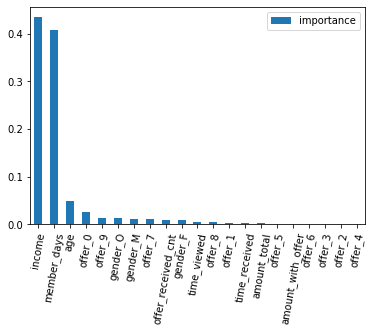

In [138]:
columns = keep_cols

feature_importances = pd.DataFrame(target_model.best_estimator_.steps[1][1].feature_importances_,
                     index = columns, columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()  # series 直接画图  .hist()
plt.xticks(rotation=80)   

### Q3.2 Summary: Will an offer effective?(already sent)
1. As a reference model, KNeighborsClassifier performs not bad.
2. DecisionTreeClassifier and RandomForestClassifier both have a full score in training, is there something speciall?
    - Notice that: the test time if much more less than train time. The possible reason is that the data set has a simple structure so that all predict with same result(see the deploy: no matter how i change the input data, it all shows the same result.)

P.S.: I've used the GradientBoostingClassifier as the target model to deploy my project.

### <a claa="anchor" id="3.3">[Q3.3 Given a person, recommend an offer with the most effctivity.](#Start)</a>

1. Dataset: The data as follows (in label_group)
    - tried: in this group exists transaction(s)
    - effective_offer
<br>
2. Target

| Target | Value | Meaning |
| :- | :-: | :- |
| offer_(10 classes) | 0 | uneffective in this offer_id |
|              | 1 | effective in this offer_id |

3. Features

| (Number: default 1)Features | Select reason |
| :- | :- |
| age | basic info about person |
| income | basic info about person |
| member_days | basic info about person |
| (3)gender_ | basic info about person<br>(3 kinds of 0-1 variables) |
| amount_total | amount paid of all transactions |
| offer_received_cnt | number of all received offers |
| time_received | receive time for this offer |
| amount_with_offer | amount paid of transactions for this offer |
| time_viewed | view time for this offer. <br>If not, values 0.0|

In [41]:
is_group_effective = (model_dataset.label_group==1)  # tried & effctive_offer
model_dataset_effective = model_dataset[is_group_effective]

In [42]:
model_dataset_effective.groupby('offer_id').count()  #seems that the samples is far from enough

,person,time_received,time_viewed,transaction_cnt,time_completed,amount_with_offer,reward,difficulty,duration,offer_type,...,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
offer_id,,,,,,,,,,,,,,,,,,,,,
0,4574,4574,4574,4574,4574,4574,4574,4574,4574,4574,...,4574,4574,4574,4574,4574,4574,4574,4574,4574,4574
1,4645,4645,4645,4645,4645,4645,4645,4645,4645,4645,...,4645,4645,4645,4645,4645,4645,4645,4645,4645,4645
2,1623,1623,1623,1623,1623,1623,1623,1623,1623,1623,...,1623,1623,1623,1623,1623,1623,1623,1623,1623,1623
3,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340,...,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340
4,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,...,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686
5,4964,4964,4964,4964,4964,4964,4964,4964,4964,4964,...,4964,4964,4964,4964,4964,4964,4964,4964,4964,4964
6,5351,5351,5351,5351,5351,5351,5351,5351,5351,5351,...,5351,5351,5351,5351,5351,5351,5351,5351,5351,5351
7,2869,2869,2869,2869,2869,2869,2869,2869,2869,2869,...,2869,2869,2869,2869,2869,2869,2869,2869,2869,2869
8,4473,4473,4473,4473,4473,4473,4473,4473,4473,4473,...,4473,4473,4473,4473,4473,4473,4473,4473,4473,4473


In [43]:
target_cols = ['offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5',
              'offer_6', 'offer_7', 'offer_8', 'offer_9']

# 'group_effctive_offer', 'group_no_care', 'group_tried','transaction_cnt', 'time_completed' 
# have direct information to target classes
keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
             'amount_with_offer', 'amount_total', 'offer_received_cnt',
            'time_received', 'time_viewed']

features, target = select_features_target(model_dataset_effective,target_cols, keep_cols)

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #AdaBoostClassifier(),  
    MultiOutputClassifier(GradientBoostingClassifier())  #one-vs-the rest
    ]

# test for ideal with group infos
pickle_path = './models_rec.pckl'
results_rec = select_clf(pickle_path, classifiers, features, target, test_size=0.20, random_state=9)

KNeighborsClassifier trained on 27910 samples.
Train time: 0.535691499710083s
Test time: 5.152048826217651s
MSE_train: 0.0870
MSE_test: 0.1235
Training accuracy: 0.2369
Test accuracy: 0.0489
              precision    recall  f1-score   support

           0     0.1377    0.0499    0.0732       922
           1     0.1559    0.0571    0.0836       928
           2     0.0370    0.0060    0.0104       331
           3     0.1058    0.0234    0.0383       471
           4     0.1622    0.0178    0.0320       338
           5     0.1521    0.0649    0.0910      1017
           6     0.1670    0.0768    0.1052      1016
           7     0.1481    0.0367    0.0588       545
           8     0.1682    0.0576    0.0858       938
           9     0.0538    0.0106    0.0177       472

   micro avg     0.1470    0.0489    0.0734      6978
   macro avg     0.1288    0.0401    0.0596      6978
weighted avg     0.1400    0.0489    0.0713      6978
 samples avg     0.0489    0.0489    0.0489      69

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier trained on 27910 samples.
Train time: 2.1677582263946533s
Test time: 0.016993045806884766s
MSE_train: 0.0000
MSE_test: 0.1702
Training accuracy: 1.0000
Test accuracy: 0.1489
              precision    recall  f1-score   support

           0     0.1765    0.1757    0.1761       922
           1     0.1470    0.1476    0.1473       928
           2     0.0799    0.0755    0.0776       331
           3     0.0640    0.0658    0.0649       471
           4     0.2123    0.2041    0.2081       338
           5     0.1762    0.1701    0.1731      1017
           6     0.1810    0.1890    0.1849      1016
           7     0.1439    0.1486    0.1462       545
           8     0.1302    0.1269    0.1285       938
           9     0.1029    0.1059    0.1044       472

   micro avg     0.1489    0.1489    0.1489      6978
   macro avg     0.1414    0.1409    0.1411      6978
weighted avg     0.1490    0.1489    0.1489      6978
 samples avg     0.1489    0.1489    0.1489  

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultiOutputClassifier trained on 27910 samples.
Train time: 54.60474991798401s
Test time: 0.12692713737487793s
MSE_train: 0.0985
MSE_test: 0.1000
Training accuracy: 0.0191
Test accuracy: 0.0103
              precision    recall  f1-score   support

           0     0.4783    0.0119    0.0233       922
           1     0.0000    0.0000    0.0000       928
           2     0.0000    0.0000    0.0000       331
           3     0.0000    0.0000    0.0000       471
           4     0.6774    0.0621    0.1138       338
           5     0.0000    0.0000    0.0000      1017
           6     0.4000    0.0020    0.0039      1016
           7     0.5211    0.0679    0.1201       545
           8     0.3333    0.0011    0.0021       938
           9     0.0000    0.0000    0.0000       472

   micro avg     0.4932    0.0103    0.0202      6978
   macro avg     0.2410    0.0145    0.0263      6978
weighted avg     0.2398    0.0103    0.0188      6978
 samples avg     0.0103    0.0103    0.0103     

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
results_rec

,model,train_time,test_time,train_score,test_score
0,KNeighborsClassifier,0.535691,5.152049,0.236869,0.048868
1,DecisionTreeClassifier,2.167758,0.016993,1.000000,0.148897
2,RandomForestClassifier,31.097193,1.230297,0.999534,0.008169
3,MultiOutputClassifier,54.604750,0.126927,0.019061,0.010318


### Q3.3 Summary:  Recommend an offer with the most effctivity.
1. For all, the predicting performs are totally bad.
    - But still, DecisionTreeClassifier and RandomForestClassifier have high score in training, what's going on?
        - Notice that: the test time if much more less than train time. The possible reason is that the data set has a simple structure so that all predict with same result(see the deploy: no matter how i change the input data, it all shows the same result.)
2. Pay attention to that the GradientBoostingClassifier() is not suitable for multi-class problem.  
So I used MultiOutputClassifier(GradientBoostingClassifier())

## <a class="anchor" id="4">[IV. Build neural network for regeression](#Start)</a>

In [44]:
import torch
from torch import optim

import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier

from sklearn.utils import shuffle
torch.manual_seed(0)

In [45]:
class Classifier(nn.Module):
    '''Initial the neural network'''
    def __init__(self, inputs=18, hidden=7, outputs=1):
        super().__init__()
        self.fc1 = nn.Linear(inputs, hidden)  # 18 features as input
        self.fc2 = nn.Linear(hidden, outputs)
        self.dropout = nn.Dropout(p=0.25)

        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  #回归直接输出，单分类sigmoid, 多分类soft_max... 
        return x

In [47]:
target_cols = 'amount_total'

keep_cols = ['age', 'income', 'member_days', 'gender_F', 'gender_M', 'gender_O',
             'reward', 'difficulty','duration', 'email', 'mobile', 'social', 'web',
             'transaction_cnt', 'offer_received_cnt',
             'group_effctive_offer', 'group_no_care', 'group_tried']
            
# shuffle the dataset
model_dataset_input = shuffle(model_dataset)
features, target = select_features_target(model_dataset_input, target_cols, keep_cols)

# change DataFrame to tensor('float')
features_array, target_array = np.array(features), np.array(target)
features_tensor, target_tensor = torch.from_numpy(features_array).float(), torch.from_numpy(target_array).float()


X_train, X_test, y_train, y_test = train_test_split(features_tensor, target_tensor, 
                                                        test_size=0.2, 
                                                        random_state=9)

In [48]:
# Build a model
model = Classifier()  #default (18, 7, 1)
criterion = nn.MSELoss() # criterion = nn.NLLLoss() 针对对分类变量
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train the net model
epochs = 20
train_size = X_train.shape[0]
test_size = X_test.shape[0]

train_losses, test_losses = [], []
for e in range(epochs):
    start = time()
    running_loss = 0
    for idx in range(train_size):
        features, target = X_train[idx], y_train[idx]
        
        # clear the previous gradient
        optimizer.zero_grad()
        # forward and backward
        output = model(features)
        loss = criterion(output, target)
        loss.backward()
        # update model/weights
        optimizer.step()
        
        running_loss += loss.item()
    
    test_loss = 0
    with torch.no_grad(): # in test mode without calculating of gradient
        model.eval()  # in test mode without dropout()
        
        for idx in range(test_size):
            features, target = X_test[idx], y_test[idx]
            
            output = model(features)  #回归分析，没有标签accuracy的计算
            test_loss += criterion(output, target)
            
    train_losses.append(running_loss/train_size)
    test_losses.append(test_loss/test_size)
        
    model.train() # back to train mode
    end = time()
    print("epoch:{}/{}.." .format(e+1, epochs), 
        "Training Loss: {:.3f}..".format(running_loss/train_size),
        "Test Loss: {:.3f}..".format(test_loss/test_size),
        "Time Cost: {:.3f}s..".format(end-start))

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:1/20.. Training Loss: 20550.215.. Test Loss: 16089.338.. Time Cost: 85.232s..
epoch:2/20.. Training Loss: 18629.431.. Test Loss: 15645.789.. Time Cost: 108.798s..
epoch:3/20.. Training Loss: 18059.719.. Test Loss: 15397.492.. Time Cost: 88.476s..
epoch:4/20.. Training Loss: 18591.784.. Test Loss: 17092.785.. Time Cost: 84.721s..
epoch:5/20.. Training Loss: 17867.469.. Test Loss: 16893.158.. Time Cost: 106.455s..
epoch:6/20.. Training Loss: 17776.402.. Test Loss: 16882.059.. Time Cost: 88.753s..
epoch:7/20.. Training Loss: 17767.603.. Test Loss: 16883.391.. Time Cost: 87.397s..
epoch:8/20.. Training Loss: 17766.653.. Test Loss: 16884.016.. Time Cost: 97.170s..
epoch:9/20.. Training Loss: 17766.521.. Test Loss: 16884.375.. Time Cost: 93.455s..
epoch:10/20.. Training Loss: 17766.495.. Test Loss: 16884.461.. Time Cost: 150.855s..
epoch:11/20.. Training Loss: 17766.488.. Test Loss: 16884.436.. Time Cost: 90.398s..
epoch:12/20.. Training Loss: 17766.486.. Test Loss: 16884.402.. Time Co

### Summary: Neural Network for regeression
This experiment for regression analysing seems useless 

### Summary in all:
1. The data set maybe too small or not so typical for a Machine Learning model to learn from the data.


## <a class="anchor" id="References">[References](#Start)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>


# Tips(for myself)

### Model
1. Attribute:
    - best_estimator_  
    - best_params_  
    - best_score_
    - feature_importances_
    
    ```python
    columns = keep_cols
    feature_importances = pd.DataFrame(models['clf'].feature_importances_,
                           index = columns, columns=['importance']).sort_values('importance',ascending=False)
    
    feature_importances.plot.bar()  # series 直接画图  .hist()
    plt.xticks(rotation=80)                                                  
    ```

2. Method:
    - .predict_proba(X_test): 返回概率值  第一列为0， 第二列为1  10 lables * 3 recods(inputs) * 2 outputs

3. Data I/O
    ```python
    with open(r"./.pckl", "rb") as f:
        # 加载1个模型
        models = pickle.load(f)  
        
        # 加载多个模型
        while True:
            try:
                models=pickle.load(f)
                print(models)
            except EOFError:
                break
    ```

### NN with Pipeline

```python
net = NeuralNetClassifier(MyModule, max_epochs=10, lr=0.1,)
pipe = Pipeline([('preprocessor', StandardScaler()),
             ('clf', net)
            ])
pipe.fit

# 但是训练过程中如何设置：dropout()还有梯度清零，反向更新？
# model.eval()  model.train()
```